In [4]:
import os
from pycbc.filter.matchedfilter import match
from pycbc.types.frequencyseries import FrequencySeries
import numpy as np
import bilby
import pyEFPE
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

## Set up the parameters

In [5]:
Gamma = 0.5772156649015329
Pi = np.pi
MTSUN_SI = 4.925491025543576e-06

def findchirp_chirptime(m1, m2, fmin):
    """
    Time taken from f_min to f_lso (last stable orbit). 3.5PN in fourier phase considered.

    Parameters
    ----------
    m1 : `float`
        Mass of the first body in solar masses.
    m2 : `float`
        Mass of the second body in solar masses.
    fmin : `float`
        Lower frequency cutoff.

    Returns
    -------
    chirp_time : float
        Time taken from f_min to f_lso (last stable orbit frequency).
    """

    # variables used to compute chirp time
    m = m1 + m2
    eta = m1 * m2 / m / m
    c0T = c2T = c3T = c4T = c5T = c6T = c6LogT = c7T = 0.0

    c7T = Pi * (
        14809.0 * eta * eta / 378.0 - 75703.0 * eta / 756.0 - 15419335.0 / 127008.0
    )

    c6T = (
        Gamma * 6848.0 / 105.0
        - 10052469856691.0 / 23471078400.0
        + Pi * Pi * 128.0 / 3.0
        + eta * (3147553127.0 / 3048192.0 - Pi * Pi * 451.0 / 12.0)
        - eta * eta * 15211.0 / 1728.0
        + eta * eta * eta * 25565.0 / 1296.0
        + eta * eta * eta * 25565.0 / 1296.0
        + np.log(4.0) * 6848.0 / 105.0
    )
    c6LogT = 6848.0 / 105.0

    c5T = 13.0 * Pi * eta / 3.0 - 7729.0 * Pi / 252.0

    c4T = 3058673.0 / 508032.0 + eta * (5429.0 / 504.0 + eta * 617.0 / 72.0)
    c3T = -32.0 * Pi / 5.0
    c2T = 743.0 / 252.0 + eta * 11.0 / 3.0
    c0T = 5.0 * m * MTSUN_SI / (256.0 * eta)

    # This is the PN parameter v evaluated at the lower freq. cutoff
    xT = np.power(Pi * m * MTSUN_SI * fmin, 1.0 / 3.0)
    x2T = xT * xT
    x3T = xT * x2T
    x4T = x2T * x2T
    x5T = x2T * x3T
    x6T = x3T * x3T
    x7T = x3T * x4T
    x8T = x4T * x4T

    # Computes the chirp time as tC = t(v_low)
    # tC = t(v_low) - t(v_upper) would be more
    # correct, but the difference is negligble.
    return (
        c0T
        * (
            1
            + c2T * x2T
            + c3T * x3T
            + c4T * x4T
            + c5T * x5T
            + (c6T + c6LogT * np.log(xT)) * x6T
            + c7T * x7T
        )
        / x8T
    )

In [ ]:
time_of_event = 1126259642.413
post_trigger_duration = 1.
duration = 309.0
analysis_start = time_of_event + post_trigger_duration - duration
sampling_frequency = 2048.
f_min = 20.0

injection_parameters = {'mass_1':1.61, 'mass_2':1.18, 'eccentricity':0.0, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':0., 'phase':0.}

mass_1_ = injection_parameters['mass_1']
mass_2_ = injection_parameters['mass_2']
#f_max = 128.
f_max = (C**3)/( G*(mass_1_+mass_2_)*Mo*np.pi*6**(3/2) )

## Set up pyEFPE waveform

In [ ]:
pyEFPE.pyEFPE?

In [40]:

def waveform_generator5(parameters, frequency_array, f_min=20.0):
    
    params = {
    'mass1': parameters['mass_1'],       # Mass of companion 1 (solar masses)
    'mass2': parameters['mass_2'],       # Mass of companion 2 (solar masses)
    'e_start': parameters['eccentricity'],     # Initial eccentricity
    'spin1x': 0.,
    'spin1y': 0.,
    'spin1z': 0.,
    'spin2x': 0.,    # Spin components of companion 2
    'spin2y': 0.,
    'spin2z': 0.,
    'distance': parameters['luminosity_distance'], # Luminosity distance (Mpc)
    'inclination': parameters['theta_jn'],# Initial binary inclination (radians)
    'f22_start': f_min,    # Starting (simulation) waveform frequency of GW 22 mode (Hz)
    #'f22_end': f_max,  # Ending frequency of GW 22 mode (Hz)
    'phi_start': parameters['phase'], # Initial phase of the binary (radians)
    }
    # Initialize pyEFPE waveform model
    wf = pyEFPE.pyEFPE(params)

    # Compute frequency-domain gravitational wave polarizations
    hp, hc = wf.generate_waveform(frequency_array)

    return {'plus': hp, 'cross': hc}

## Set up other waveforms

In [48]:
############# TF2Ecck waveform model ################
waveform_arguments1 = dict(waveform_approximant='TaylorF2Ecck',
                          reference_frequency=f_min, minimum_frequency=f_min)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_binary_black_hole_no_spins,
    parameters=injection_parameters, waveform_arguments=waveform_arguments1)

############# TF2Ecch waveform model ################
waveform_arguments2 = dict(waveform_approximant='TaylorF2Ecch',
                          reference_frequency=f_min, minimum_frequency=f_min)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_binary_black_hole_no_spins,
    parameters=injection_parameters, waveform_arguments=waveform_arguments2)

############# TF2Ecc waveform model ################
waveform_arguments3 = dict(waveform_approximant='TaylorF2Ecc',
                          reference_frequency=f_min, minimum_frequency=f_min, pn_phase_order=7, pn_tidal_order=0)

waveform_generator3 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_binary_black_hole_no_spins,
    parameters=injection_parameters, waveform_arguments=waveform_arguments3)

############# TaylorF2 waveform model ################
waveform_arguments4 = dict(waveform_approximant='TaylorF2',
                          reference_frequency=f_min, minimum_frequency=f_min, pn_phase_order=7, pn_amplitude_order=0, pn_tidal_order=0)

waveform_generator4 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_binary_black_hole_no_spins,
    parameters=injection_parameters, waveform_arguments=waveform_arguments4)

ifos = bilby.gw.detector.InterferometerList(['L1'])
ifos.set_strain_data_from_zero_noise(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=analysis_start)

15:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_binary_black_hole_no_spins
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_binary_black_hole_no_spins
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_binary_black_hole_no_spins
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:50 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_binary_black_hole_no_spins
  time_domain_source_model: None
  parameter_conversi

## Initial check with pyEFPE and TaylorF2 (3.5PN order)

In [46]:
polas_a = waveform_generator4.frequency_domain_strain(parameters = injection_parameters) # TF2Ecck
polas_b = waveform_generator5(parameters = injection_parameters, frequency_array=waveform_generator4.frequency_array) # pyEFPE
arr_a = FrequencySeries(polas_a['plus'], delta_f=1/duration)
arr_b = FrequencySeries(polas_b['plus'], delta_f=1/duration)
psd_ = FrequencySeries(ifos[0].power_spectral_density_array, delta_f=1/duration)
match(arr_a, arr_b, psd=psd_, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max)

(0.9647350280801859, 632826)

* pyEFPE doesn't match TaylorF2 at $e_0=0.0$

## TaylorF2Ecck vs pyEFPE

In [91]:
size2 = 20 # number of eccentricity values
eccn_array = np.linspace(0.0,0.15,size2)

In [92]:
create_new = True
if (not os.path.exists('match_array_15_pyEFPE.npy')) or create_new:
    mass_1_ = 1.61
    mass_2_ = 1.18
    #f_max = 128.
    f_max = (C**3)/( G*(mass_1_+mass_2_)*Mo*np.pi*6**(3/2) )

    safety = 1.0
    approx_duration = safety * findchirp_chirptime(mass_1_, mass_2_, f_min)
    duration = np.ceil(approx_duration)
    # duration = 309.

    match_array_list = []
    for eccn in eccn_array:

        injection_parameters = {'mass_1':mass_1_, 'mass_2':mass_2_, 'eccentricity':eccn, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 'phase':0.}
        
        polas_a = waveform_generator1.frequency_domain_strain(parameters = injection_parameters) # TF2Ecck
        polas_b = waveform_generator5(parameters = injection_parameters, frequency_array=waveform_generator1.frequency_array)
        arr_a = FrequencySeries(polas_a['plus'], delta_f=1/duration)
        arr_b = FrequencySeries(polas_b['plus'], delta_f=1/duration)
        psd_ = FrequencySeries(ifos[0].power_spectral_density_array, delta_f=1/duration)

        
        match_array_list.append(match(arr_a, arr_b, psd=psd_, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max))

    match_array_15 = np.array(match_array_list)[:,0]
    # save data
    np.save('match_array_15_pyEFPE.npy', np.array(match_array_15))
else:
    match_array_15 = np.load('match_array_15_pyEFPE.npy')

## TaylorF2Ecc (3.5PN order) vs pyEFPE

In [93]:
create_new = True
if (not os.path.exists('match_array_35_pyEFPE.npy')) or create_new:
    mass_1_ = 1.61
    mass_2_ = 1.18
    #f_max = 128.
    f_max = (C**3)/( G*(mass_1_+mass_2_)*Mo*np.pi*6**(3/2) )

    safety = 1.0
    approx_duration = safety * findchirp_chirptime(mass_1_, mass_2_, f_min)
    duration = np.ceil(approx_duration)
    # duration = 309.

    match_array_list = []
    for eccn in eccn_array:
        injection_parameters = {'mass_1':mass_1_, 'mass_2':mass_2_, 'eccentricity':eccn, 'a_1':0., 'a_2':0., 'tilt_1':0., 'tilt_2':0., 'phi_12':0., 'phi_jl':0., 'luminosity_distance':38.87, 'theta_jn':2.52, 'psi':3.293627, 'phase':0.}
        polas_a = waveform_generator3.frequency_domain_strain(parameters = injection_parameters) # TF2Ecch
        polas_b = waveform_generator5(parameters = injection_parameters, frequency_array=waveform_generator3.frequency_array)
        arr_a = FrequencySeries(polas_a['plus'], delta_f=1/duration)
        arr_b = FrequencySeries(polas_b['plus'], delta_f=1/duration)
        psd_ = FrequencySeries(ifos[0].power_spectral_density_array, delta_f=1/duration)
        match_array_list.append(match(arr_a, arr_b, psd=psd_, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max))
    match_array_35 = np.array(match_array_list)[:,0]
    # save data
    np.save('match_array_35_pyEFPE.npy', np.array(match_array_35))
else:
    match_array_35 = np.load('match_array_35_pyEFPE.npy')


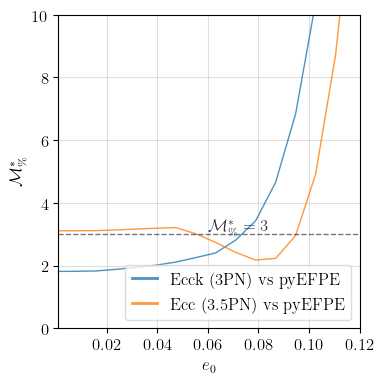

In [94]:
size2 = 20

# Setup the figure
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12
})
plt.figure(figsize=(4., 4.))

# First plot (mismatch percentage)
plt.plot(eccn_array, (1 - match_array_15) * 100, 'C0', alpha=0.8, linewidth=1)
plt.plot(eccn_array, (1 - match_array_35) * 100, 'C1', alpha=0.8, linewidth=1)

# Labeling the first plot
plt.xlabel(r"$e_0$", fontdict={'fontsize': 12})
plt.ylabel(r"${\cal M}^*_{\%}$", fontdict={'fontsize': 12})

legend = plt.legend(['Ecck (3PN) vs pyEFPE', 'Ecc (3.5PN) vs pyEFPE'], handlelength=1.5, loc='lower right', bbox_to_anchor=(1.0, 0.0), frameon=True, fontsize=12, edgecolor='lightgray')
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
# Modify line width for legend entries
for handle in legend.get_lines():
    handle.set_linewidth(2)
    handle.set_alpha(0.8)

plt.xlim(0.001, 0.12)
plt.ylim(0.0, 10)
plt.axhline(y=3.0, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
plt.text(0.06, 3.12, r'${\cal M}^*_{\%}=3$', color='#1B1833', fontsize=12, alpha=0.9)

# plt.axvline(x=0.014661661290850475, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
# plt.text(0.014661661290850475+0.005, 1.1, r'$e_0=0.015$', color='#1B1833', fontsize=12, alpha=0.9, rotation=90)
# plt.axvline(x=0.15944421846787388, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
# plt.text(0.15944421846787388+0.005, 1.1, r'$e_0=0.159$', color='#1B1833', fontsize=12, alpha=0.9, rotation=90)
# plt.axvline(x=0.22825769595155887, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
# plt.text(0.22825769595155887+0.005, 1.1, r'$e_0=0.228$', color='#1B1833', fontsize=12, alpha=0.9, rotation=90)

# Show the combined plot
plt.grid(True, alpha=0.4)
plt.tight_layout()
# plt.savefig('./mismatch_vs_eccn.pdf')
plt.show()

## Remove off-set at $e_0=0.0$

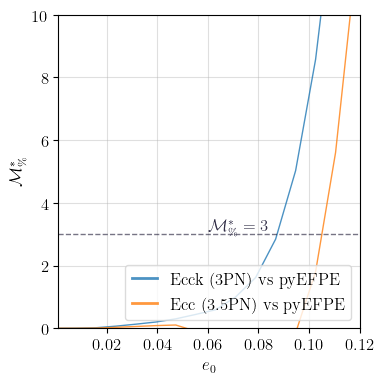

In [103]:
# size2 = 20

# Setup the figure
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12
})
plt.figure(figsize=(4., 4.))

# First plot (mismatch percentage)
mismatch_array_15 = (1 - match_array_15) * 100
mismatch_array_35 = (1 - match_array_35) * 100
plt.plot(eccn_array, mismatch_array_15-mismatch_array_15[0], 'C0', alpha=0.8, linewidth=1)
plt.plot(eccn_array,  mismatch_array_35-mismatch_array_35[0], 'C1', alpha=0.8, linewidth=1)

# Labeling the first plot
plt.xlabel(r"$e_0$", fontdict={'fontsize': 12})
plt.ylabel(r"${\cal M}^*_{\%}$", fontdict={'fontsize': 12})

legend = plt.legend(['Ecck (3PN) vs pyEFPE', 'Ecc (3.5PN) vs pyEFPE'], handlelength=1.5, loc='lower right', bbox_to_anchor=(1.0, 0.0), frameon=True, fontsize=12, edgecolor='lightgray')
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
# Modify line width for legend entries
for handle in legend.get_lines():
    handle.set_linewidth(2)
    handle.set_alpha(0.8)

plt.xlim(0.001, 0.12)
plt.ylim(0.0, 10)
plt.axhline(y=3.0, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
plt.text(0.06, 3.12, r'${\cal M}^*_{\%}=3$', color='#1B1833', fontsize=12, alpha=0.9)

# plt.axvline(x=0.014661661290850475, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
# plt.text(0.014661661290850475+0.005, 1.1, r'$e_0=0.015$', color='#1B1833', fontsize=12, alpha=0.9, rotation=90)
# plt.axvline(x=0.15944421846787388, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
# plt.text(0.15944421846787388+0.005, 1.1, r'$e_0=0.159$', color='#1B1833', fontsize=12, alpha=0.9, rotation=90)
# plt.axvline(x=0.22825769595155887, color='#1B1833', linestyle='--', linewidth=1, alpha=0.6)
# plt.text(0.22825769595155887+0.005, 1.1, r'$e_0=0.228$', color='#1B1833', fontsize=12, alpha=0.9, rotation=90)

# Show the combined plot
plt.grid(True, alpha=0.4)
plt.tight_layout()
# plt.savefig('./mismatch_vs_eccn.pdf')
plt.show()